## Based on: http://www.bmva.org/bmvc/2015/papers/paper109/paper109.pdf

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [50, 10]
from PIL import Image
from PIL import ImageOps
from PIL import Image, ImageDraw
from sklearn.utils import shuffle
import tensorflow as tf
import seaborn as sn
import numpy as np
import pandas as pd
from flow_from_dataframe import flow_from_dataframe
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
%matplotlib inline

Using TensorFlow backend.


In [2]:
KITTI_IMAGE_WIDTH = 1242
STIXEL_WIDTH = 24
IMAGE_SIZE = (370,STIXEL_WIDTH)
maximum_offset = KITTI_IMAGE_WIDTH//STIXEL_WIDTH 
BATCH_SIZE = 1000
NUMBER_OF_BINS = 50

In [8]:
df = pd.read_csv('data_train/labels_no.csv')
# bin labels
bins = np.linspace(0, 370, NUMBER_OF_BINS)
binned_values = []
for index, row in df.iterrows():
    binned_values.append(np.argmax(np.histogram(row['y'],bins)[0]))
df['binned_y'] = pd.Series(binned_values)
df.head()

,img_path,y,binned_y
0,data_train/stixels/2.png,242,32
1,data_train/stixels/3.png,237,31
2,data_train/stixels/4.png,236,31
3,data_train/stixels/5.png,229,30
4,data_train/stixels/6.png,229,30


In [19]:
df

,img_path,y,binned_y
0,data_train/stixels/2.png,242,32
1,data_train/stixels/3.png,237,31
2,data_train/stixels/4.png,236,31
3,data_train/stixels/5.png,229,30
4,data_train/stixels/6.png,229,30
...,...,...,...
118227,data_train/stixels/355341.png,335,44
118228,data_train/stixels/355342.png,334,44
118229,data_train/stixels/355343.png,334,44
118230,data_train/stixels/355344.png,334,44


In [56]:
relatives = []
for val in list(values_distribution):
    if(val == 0):
        relatives.append(0)
    else:
        relatives.append(val/sum(values_distribution))


NameError: name 'values_distribution' is not defined

In [435]:
sum(relatives[150:350])

0.995060558901143

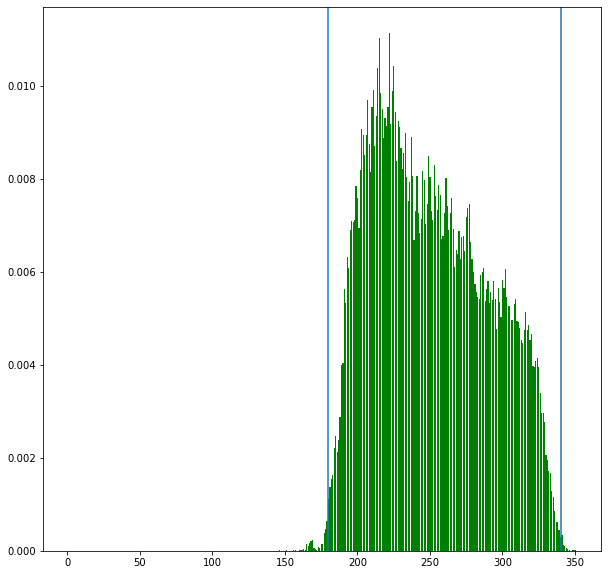

In [434]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.bar(np.linspace(1,max(df['y'])+1,max(df['y'])+1), relatives, color='green')
plt.axvline(x=180, ymin=0, ymax=1)
plt.axvline(x=340, ymin=0, ymax=1)

In [9]:
test_df, train_df = np.split(df, [int(len(df)*0.2)], axis=0)

core_idg = ImageDataGenerator(
    horizontal_flip = True,
    rescale=1.0/255.0)

train_generator = flow_from_dataframe(
    core_idg,train_df,
    'img_path',
    'binned_y',
    'data_train/',
    NUMBER_OF_BINS,
    target_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE)
test_generator = flow_from_dataframe(
    core_idg,test_df,
    'img_path',
    'binned_y',
    'data_train/',
    NUMBER_OF_BINS,
    target_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE)
#print('%d overlapping images.'%list(set(list(test_generator._filepaths)).intersection(list(train_generator._filepaths))))

Found 355366 images belonging to 1 classes.
Found 355366 images belonging to 1 classes.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


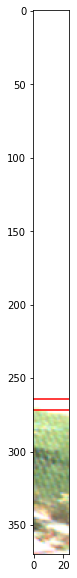

In [6]:
plt.rcParams['figure.figsize'] = [20, 10]

i=0
for t in train_generator:
    plt.imshow(t[0][0])
    print(t[1][0])
    for j in range(len(t[1][0])):
        if t[1][0][j] == 1:
            plt.axhline(y=bins[j],color='red')
            plt.axhline(y=bins[j+1],color='red')
    plt.show()
    break

In [5]:
import tensorflow as tf
import keras.backend as K


# Ground truth needs to be in that form: [ACTUAL_VALUE,BIN_OF_ACTUAL_VALUE, (NUMBER_OF_BINS-2)*Zero (zero padding)]
# This is due to keras demanding dim(y_true) == dim(y_pred) But in this case this is not wanted.
# Current notebook DOES NOT generate y_true in that manner, since this loss function is not working (for now).

def P(y,y_pred,i):
    i_1 = i+1
    a_i = K.cast(K.gather(y_pred,i),'float32')
    a_i_1 = K.cast(K.gather(y_pred,i_1),'float32')
    c_i = K.cast(K.gather(bins,i),'float32')
    c_i_1 = K.cast(K.gather(bins,i_1),'float32')
    denominator = c_i_1 - c_i
    first_half = a_i * (((c_i_1 - y) / denominator))
    second_half = a_i_1 * ((y - c_i) / denominator)
    return  first_half + second_half

def pl_loss(y_true,y_pred):
    y_true = K.cast(K.gather(y_true,0),'float32')
    y_pred = K.cast(K.flatten(y_pred),"float32")
    i = K.cast(K.gather(K.flatten(y_true),1),'int32')
    return P(y_true,y_pred,i)

In [10]:
from keras.layers import Input,Conv2D,MaxPooling2D,Dense,Dropout,Flatten
from keras import Model
from keras.optimizers import Adam

def StixelNet(loss='mean_squared_error',metrics=['accuracy'],number_of_bins=50):
    inputs = Input((IMAGE_SIZE[0],IMAGE_SIZE[1],3))
    conv1 = Conv2D(64, (5,11), activation='relu',padding='same', kernel_initializer='he_normal')(inputs)
    pool1 = MaxPooling2D(pool_size=(4, 8))(conv1)
    conv2 = Conv2D(200, (3,5), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(4, 3))(conv2)
    flattened = Flatten()(pool2)
    dense1 = Dense(1024, kernel_initializer='he_normal', activation='relu')(flattened)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(2048, kernel_initializer='he_normal', activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    dense3 = Dense(number_of_bins, kernel_initializer='he_normal', activation='softmax')(dropout2)
    model = Model(inputs=inputs, outputs=dense3)
    model.compile(optimizer=Adam(lr=0.001), loss=loss, metrics=metrics)
    return model

In [11]:
model = StixelNet(number_of_bins=NUMBER_OF_BINS,metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy()])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 370, 24, 3)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 370, 24, 64)       10624     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 92, 3, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 92, 3, 200)        192200    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 1, 200)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              4711

In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

steps_per_epoch = train_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE

#model.load_weights('best_model.hdf5')

checkpoint = ModelCheckpoint(
    "best_model.hdf5", 
    monitor='val_loss',
    verbose=1,
    save_best_only=True, 
    mode='min', 
    period=1, 
    save_weights_only=True)

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=400,
                              validation_data=test_generator,
                              validation_steps=test_steps,
                              callbacks=[checkpoint])

Epoch 1/400
18/18 [==============================] - 14s 757ms/step - loss: 0.0189 - accuracy: 0.0848 - top_k_categorical_accuracy: 0.2823 - val_loss: 0.0184 - val_accuracy: 0.1335 - val_top_k_categorical_accuracy: 0.3109

Epoch 00001: val_loss improved from inf to 0.01841, saving model to best_model.hdf5
Epoch 2/400
18/18 [==============================] - 13s 715ms/step - loss: 0.0185 - accuracy: 0.1342 - top_k_categorical_accuracy: 0.3397 - val_loss: 0.0175 - val_accuracy: 0.2285 - val_top_k_categorical_accuracy: 0.3729

Epoch 00002: val_loss improved from 0.01841 to 0.01755, saving model to best_model.hdf5
Epoch 3/400
18/18 [==============================] - 13s 722ms/step - loss: 0.0180 - accuracy: 0.1769 - top_k_categorical_accuracy: 0.4002 - val_loss: 0.0171 - val_accuracy: 0.2680 - val_top_k_categorical_accuracy: 0.4265

Epoch 00003: val_loss improved from 0.01755 to 0.01713, saving model to best_model.hdf5
Epoch 4/400
18/18 [==============================] - 13s 710ms/step - l

In [14]:
model.load_weights('best_model.hdf5')

In [18]:
model.load_weights('first/best_model_0.00954.hdf5')

In [59]:
import glob
imgs = glob.glob("trash_bins/*.jpg")
img = ImgFrame('stixel_example/0000000216.jpg')
#img = ImgFrame('trash_bag/ezgif-frame-001.jpg')

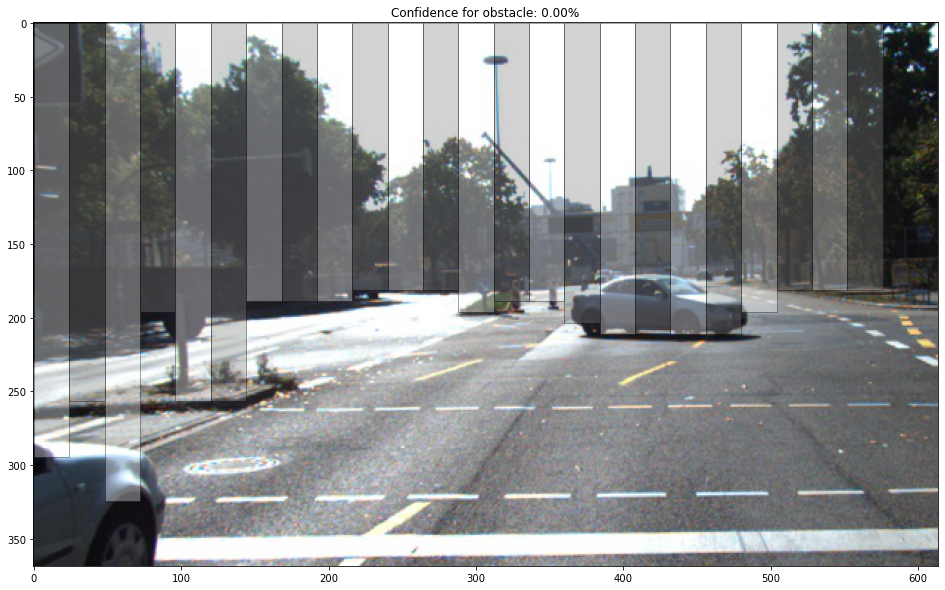

In [107]:
import matplotlib.patches as patches



#plt.rcParams['figure.figsize'] = [50, 10]
preds = model.predict(img.getImageStixels(24))
global_max = 0
for i in range(24):
    #plt.hlines(bins[np.argmax(preds[i])],(i)*24,(i+1)*24,color='red')
    #plt.vlines(i*24,0,bins[np.argmax(preds[i])])
    #plt.vlines((i+1)*24,0,bins[np.argmax(preds[i])])
    if i%2 == 0:
        color= 'white'
    else:
        color = 'gray'
    rect = patches.Rectangle(((i)*24,0),24,bins[np.argmax(preds[i])],linewidth=1,edgecolor='black',facecolor=color,alpha=0.35)
    plt.gca().add_patch(rect)
plt.title('Confidence for obstacle: %.2f%%'%global_max)
plt.imshow(img.getImage())
#plt.savefig(out_dir + '%d.png'%counter,bbox_inches='tight', pad_inches=0)
plt.show()

[1.1287568e-05, 7.4101845e-09, 6.6976063e-06, 6.612208e-06, 2.172824e-09, 1.5966984e-08, 6.2134333e-09, 4.0356922e-09, 7.120272e-09, 1.0427954e-08, 3.0705734e-09, 2.6984355e-05, 7.4949025e-09, 9.9596695e-09, 5.456887e-09, 4.9565876e-09, 7.5401094e-06, 6.956838e-05, 8.115337e-09, 8.061619e-09, 6.1321956e-09, 0.0055418834, 1.7994422e-09, 1.2594568e-09, 1.8979799e-07, 8.998495e-06, 0.000102472004, 0.001252787, 0.012276102, 0.17387365, 0.6833227, 0.121538706, 0.0015886797, 0.00023042991, 7.1449715e-05, 1.7780816e-05, 7.1081254e-06, 2.167128e-06, 4.790671e-07, 8.070689e-07, 5.143965e-07, 3.648786e-07, 1.1741231e-07, 8.897888e-09, 1.5865611e-09, 2.2313901e-07, 5.576529e-06, 1.0977387e-05, 1.0436769e-08, 1.702458e-05]


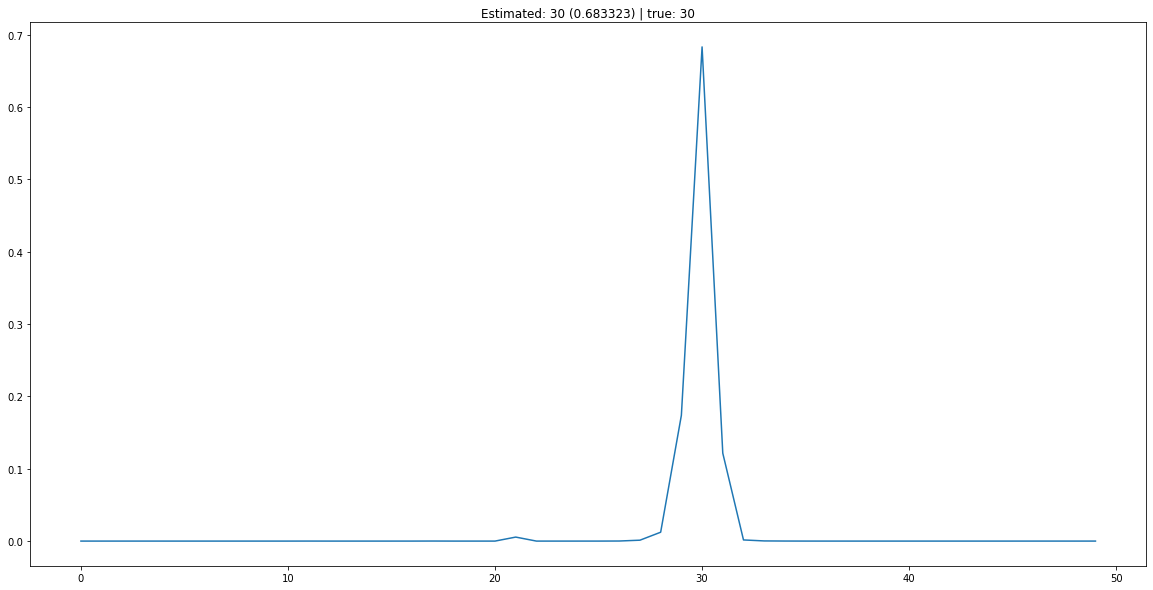

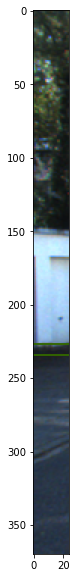

In [21]:
plt.rcParams['figure.figsize'] = [20, 10]

for t in test_generator:
    preds = model.predict(t[0])
    print(list(preds[0]))
    plt.plot(preds[0])
    plt.title('Estimated: %d (%f) | true: %d'%(np.argmax(preds[0]), max(preds[0]),np.argmax(t[1][0])))
    plt.show()
    plt.imshow(t[0][0])
    true = np.argmax(t[1][0])
    pred = np.argmax(preds[0])
    plt.axhline(y=bins[pred],color='red')
    plt.axhline(y=bins[pred+1],color='red')
    plt.axhline(y=bins[true],color='green')
    plt.axhline(y=bins[true+1],color='green')
    plt.show()
    break

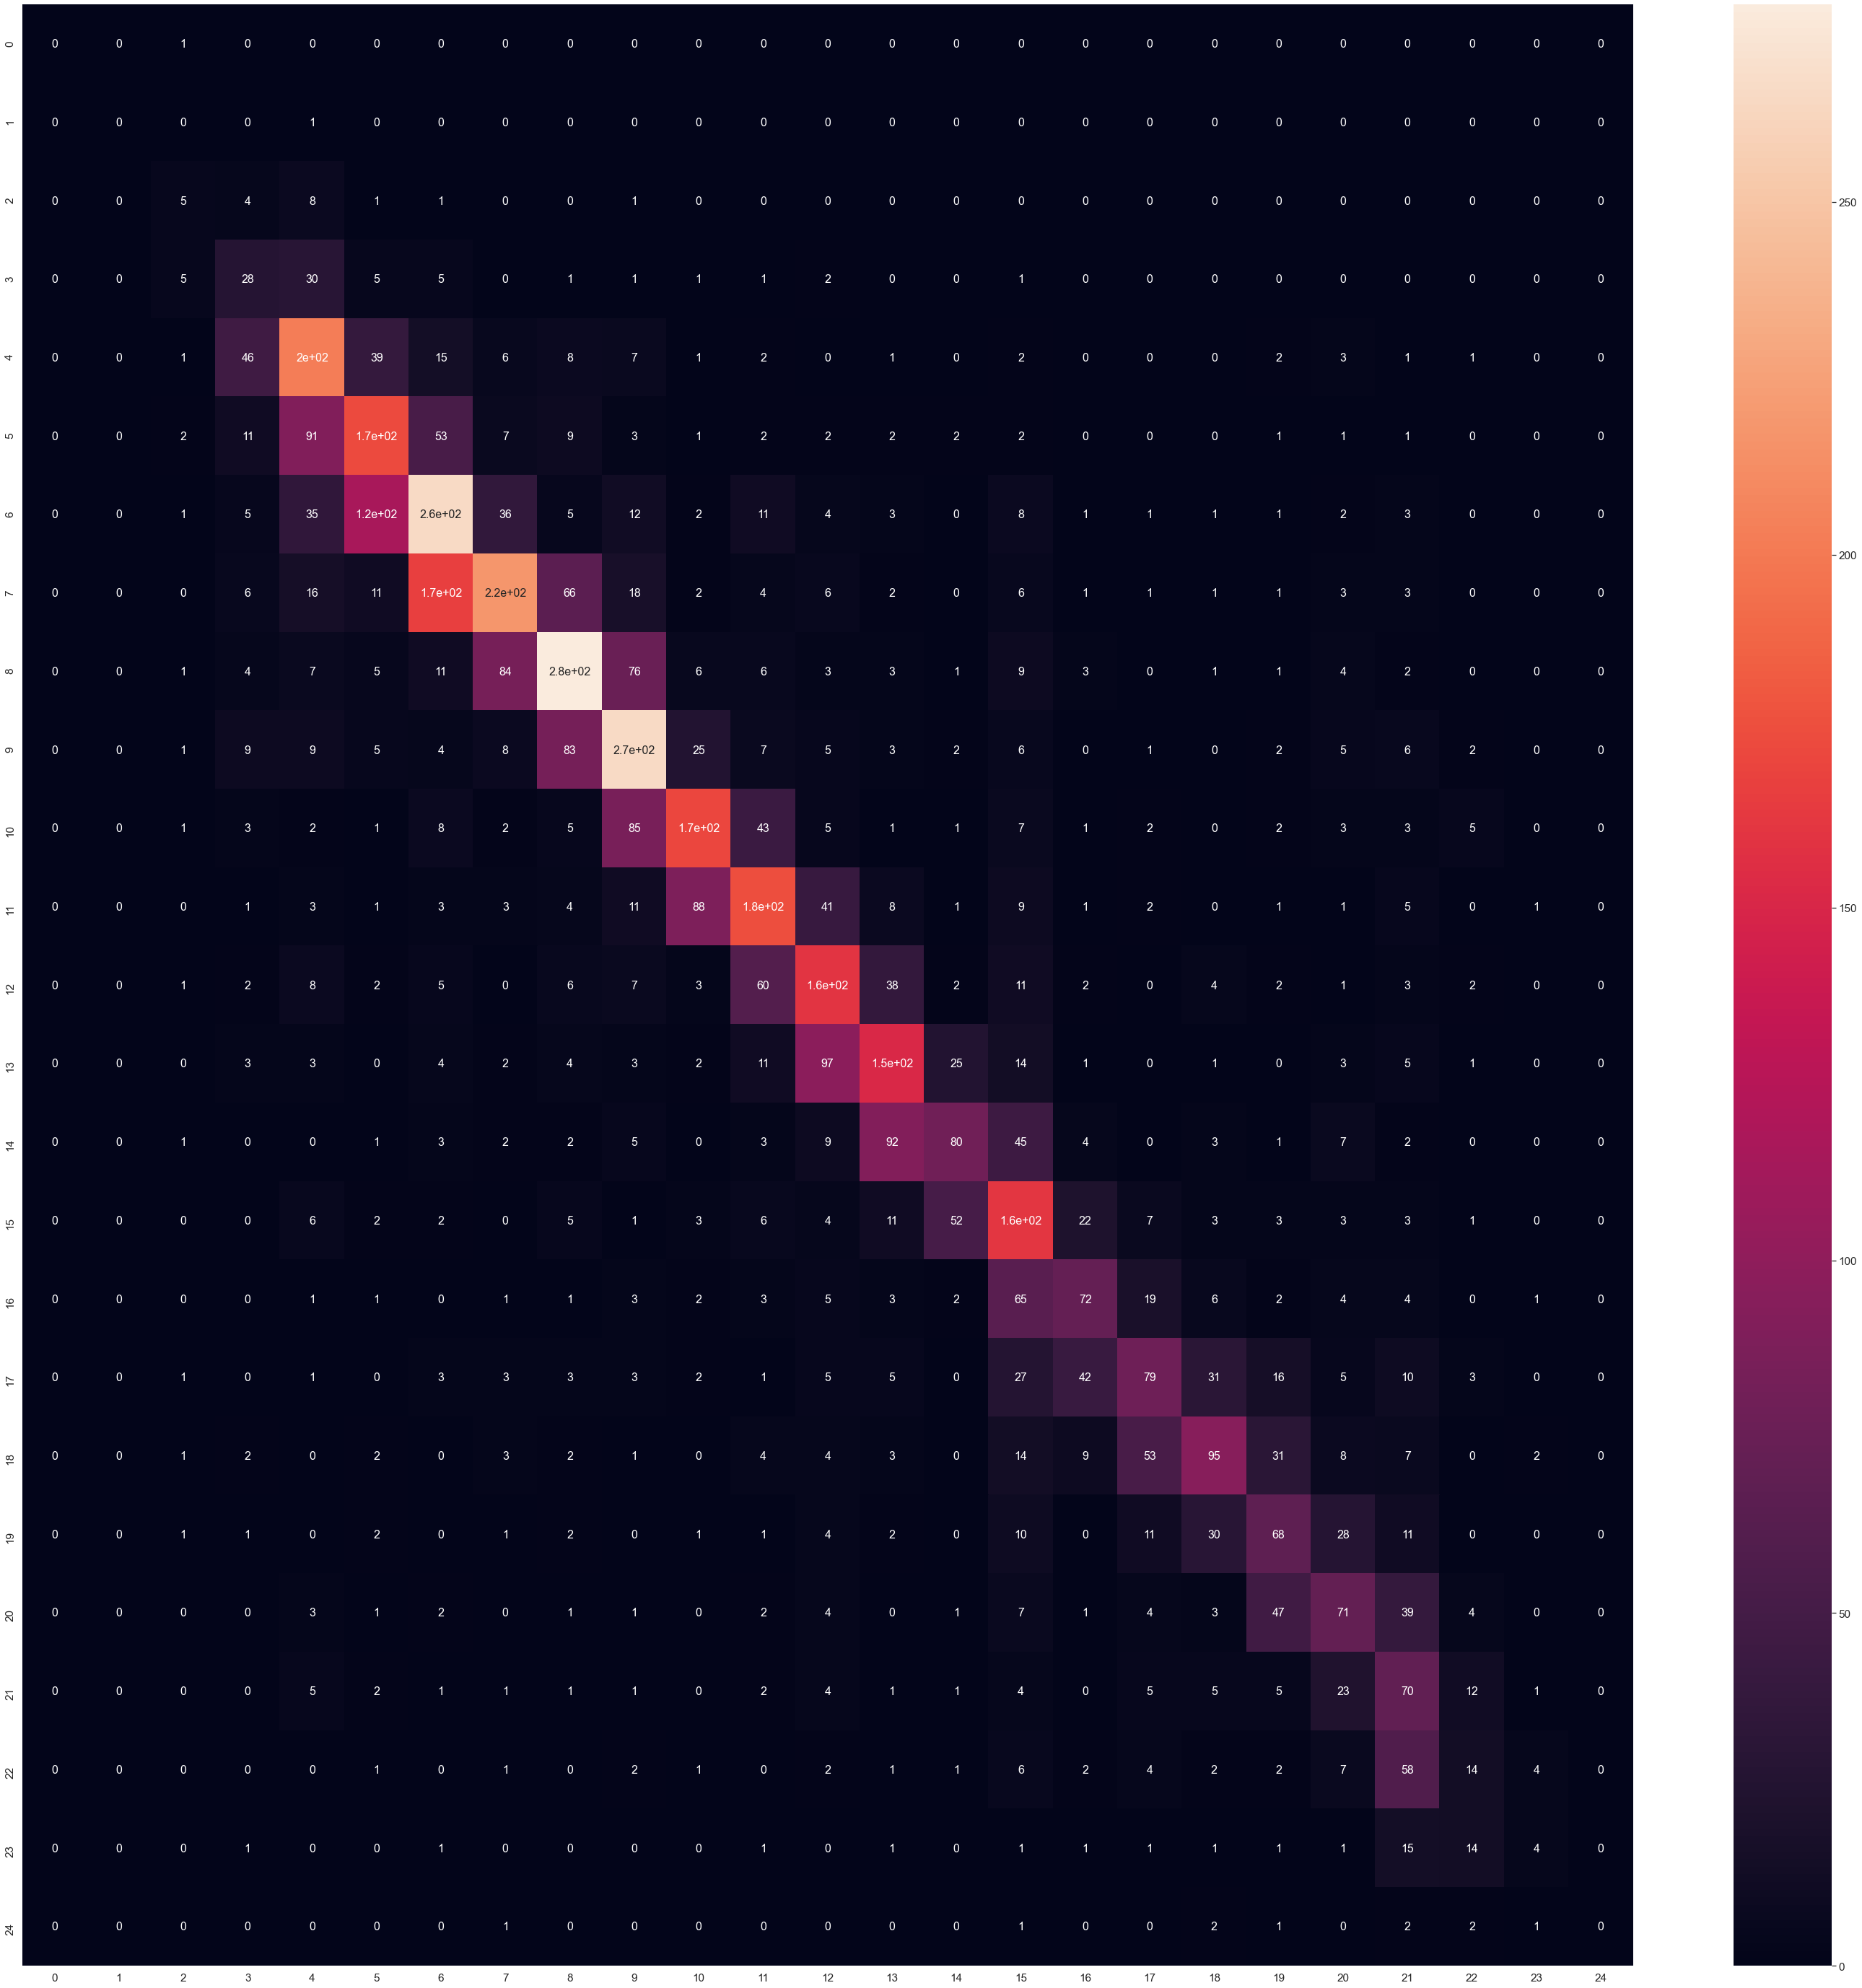

In [252]:
def preds_to_class_pred(preds):
    preds_class = []
    for i in range(len(preds)):
        preds_class.append(np.argmax(preds[i]))
    return preds_class

i = 0
y_pred = []
y_true = []
for t in test_generator:
    y_pred+=preds_to_class_pred(model.predict(t[0]))
    y_true+=preds_to_class_pred(t[1])
    if i>200:
        break
    i+=1

conf_matrix = confusion_matrix(y_true,y_pred)
df_cm = pd.DataFrame(confusion_matrix(y_true,y_pred), range(len(conf_matrix[0])), range(len(conf_matrix)))
plt.figure(figsize=(50,50))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from PIL import ImageOps

class ImgFrame:
    
    def __init__(self,imagePath):
        self.imagePath = imagePath
        self.image = Image.open(self.imagePath)
        self.image = self.image.resize((self.image.size[0],370))
        
    def getImage(self):
        return np.array(Image.open(self.imagePath))

    def getImageStixel(self,offset,stixelWidth):
        width = self.image.size[0]
        cropFromLeft = offset*stixelWidth 
        cropFromRight = width-(offset*stixelWidth)-stixelWidth
        if cropFromRight < 0:
            print('Offset too big for image.')
            return (None,-1)
        # left, up, right, bottom
        border = (cropFromLeft,0,cropFromRight, 0)
        return ImageOps.crop(self.image, border)
    
    def getImageStixels(self,stixelWidth):
        stixels = []
        for i in range(24):
            stixels.append(np.array(self.getImageStixel(i,stixelWidth)) / 255.)
        return np.array(stixels)

In [6]:
model.load_weights('training_wo_flips/best_model.hdf5')

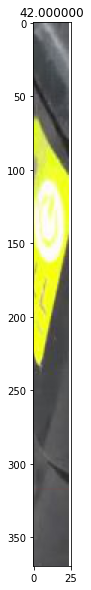

In [281]:
img = ImgFrame('trash_bins/ezgif-frame-055.jpg')
img.getImageStixels(24)[0]

preds = model.predict(img.getImageStixels(24))
stixels = img.getImageStixels(24)

for i in range(len(stixels)):
    plt.imshow(stixels[i])
    plt.title('%f'%np.argmax(preds[i]))
    plt.hlines(bins[np.argmax(preds[i])],0,24,alpha=max(preds[i]),color='red')
    plt.show()
    clear_output(wait=True)


In [274]:
import glob
imgs = glob.glob("trash_bins/*.jpg")
img = ImgFrame(imgs[0])

In [89]:
model.load_weights('best_model.hdf5')

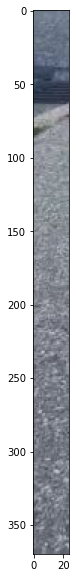

4.591836734693878
38 0.99995184


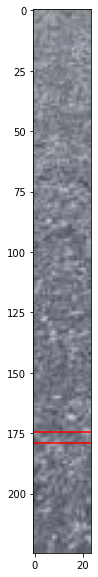

38 1.0


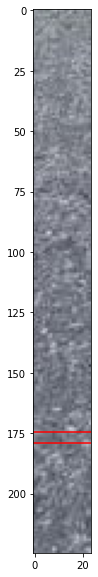

38 1.0


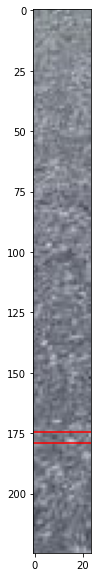

36 0.93948364


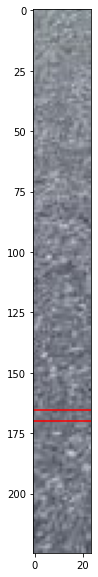

36 0.99974555


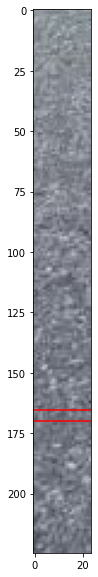

36 0.99972576


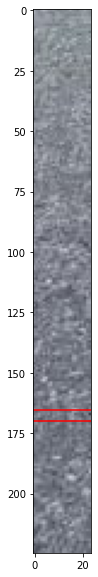

36 0.9999974


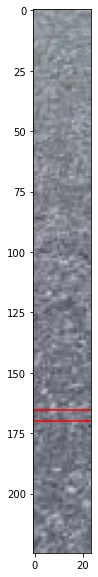

38 0.9999746


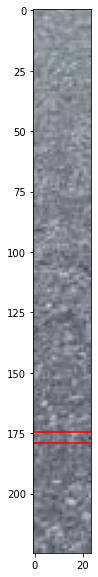

38 1.0


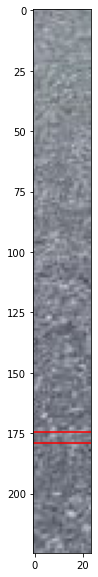

38 1.0


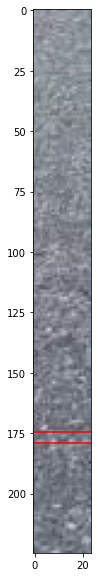

38 1.0


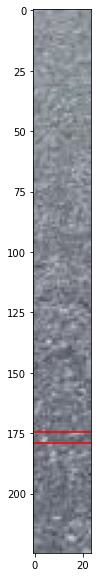

38 1.0


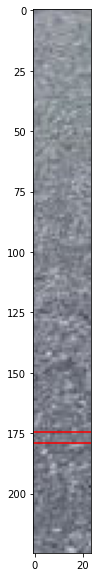

38 1.0


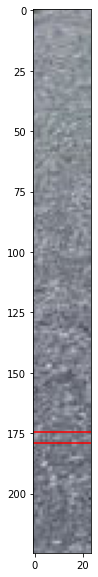

38 0.9982827


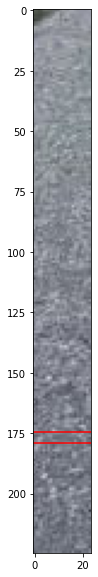

36 0.9986846


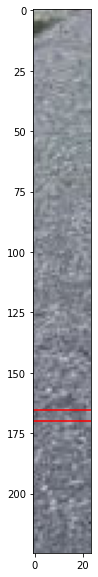

38 1.0


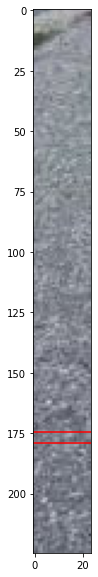

38 1.0


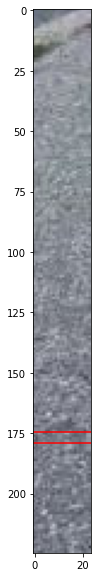

36 0.9997458


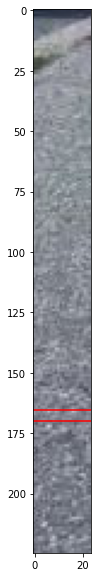

15 1.0


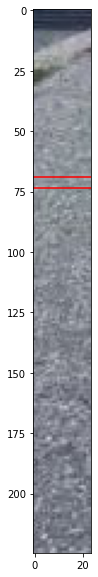

36 0.9985689


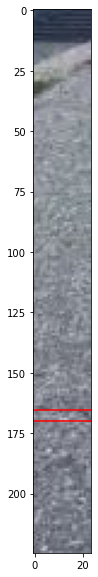

36 0.9981797


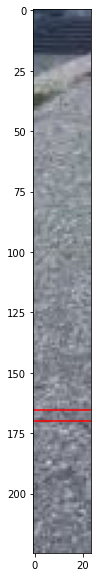

38 1.0


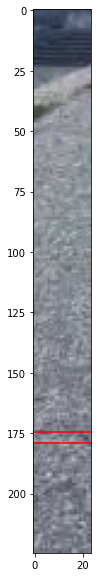

36 1.0


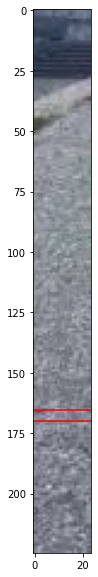

13 1.0


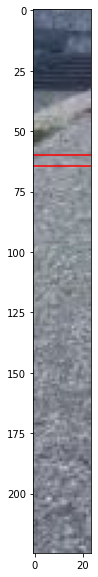

15 1.0


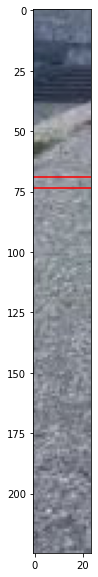

15 1.0


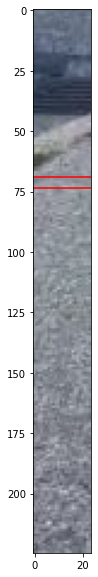

15 0.9999993


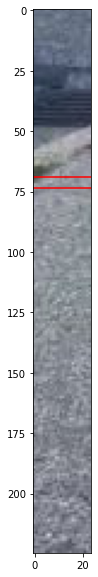

36 0.98617107


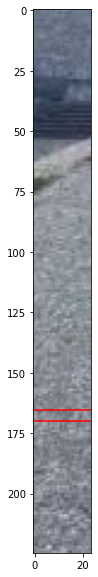

38 1.0


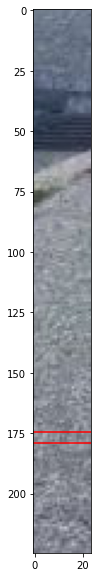

In [102]:
img = ImgFrame(imgs[80])


stixel = img.getImageStixel(3,24)


plt.imshow(stixel)
plt.show()

#plt.imshow(stixel)
#plt.show()


print(bins[1]-bins[0])

for inp in range(0,145,int(round(bins[1]-bins[0]))):
    offset = 145-inp
    #print(offset)
    cropped = ImageOps.crop(stixel, (0,145-inp,0,inp))
    cropped = np.array(cropped).reshape(1,225,24,3)
    preds = model.predict(cropped)
    pred = np.argmax(preds[0])
    print(pred,preds[0][pred])
    plt.imshow(cropped[0])
    plt.axhline(y=bins[pred],color='red')
    plt.axhline(y=bins[pred+1],color='red')
    plt.show()


if False:
    preds = model.predict(cropped)
    print(list(preds[0]))
    plt.plot(preds[0])
    plt.show()
    plt.imshow(stixel.crop(cr1))
    pred = np.argmax(preds[0])
    plt.axhline(y=bins[pred],color='red')
    plt.axhline(y=bins[pred+1],color='red')
    plt.show()



In [39]:
for i in img.getImageStixels(24):
    plt.hlines(bins[np.argmax(preds[6])],(6)*24,(6+1)*24,color='red',alpha=max(preds[6]))
    plt.imshow(i)
    plt.show()
    break

NameError: name 'img' is not defined

In [26]:
import glob
imgs = glob.glob("trash_bag/*.jpg")

threshold = 0.6
out_dir = 'trash_bins_out/'

counter = 0
for img_path in imgs:
    img = ImgFrame(img_path)
    plt.rcParams['figure.figsize'] = [50, 10]
    preds = model.predict(img.getImageStixels(24))
    global_max = 0
    for i in range(27):
        if global_max < max(preds[i]):
            global_max = max(preds[i])
        if global_max > threshold:
            plt.hlines(bins[np.argmax(preds[i])],(i)*24,(i+1)*24,color='red',alpha=max(preds[i]))
    plt.title('Confidence for obstacle: %.2f%%'%global_max)
    plt.imshow(img.getImage())
    plt.savefig(out_dir + '%d.png'%counter,bbox_inches='tight', pad_inches=0)
    counter+=1
    plt.show()
    clear_output(wait=True)

ValueError: Error when checking input: expected input_1 to have shape (225, 24, 3) but got array with shape (370, 24, 3)

In [ ]:
def splitImageStixel(stixel,split_height):
    splits = []
    stixel_height = stixel.size[1]
    for i in range(0,stixel_height-split_height+1):
        cropped = ImageOps.crop(stixel, border)
        splits.append(cropped)
    return splits


len(splitImageStixel(Image.open('data_train/stixels/270.png'),138))